# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

# Описание данных

Технологический процесс
* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    * Xanthate **— ксантогенат (промотер, или активатор флотации);
    * Sulphate — сульфат (на данном производстве сульфид натрия);
    * Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

Параметры этапов
* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso

## Подготовка данных

In [2]:
data_train = pd.read_csv('/datasets/gold_recovery_train.csv')
data_test = pd.read_csv('/datasets/gold_recovery_test.csv')
data_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [4]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

In [5]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

### Recovery

In [6]:
data_full.dropna(subset=['rougher.output.concentrate_au', 'rougher.input.feed_au',
                         'rougher.output.tail_au','rougher.output.recovery'], inplace=True)

In [7]:
T = data_full['rougher.output.tail_au']
F = data_full['rougher.input.feed_au']
C = data_full['rougher.output.concentrate_au']

In [8]:
recovery = (C*(F-T))/(F*(C-T))*100

table_recovery = data_full['rougher.output.recovery']

In [9]:
print('MAE =', mean_absolute_error(table_recovery, recovery))

MAE = 9.816196887783512e-15


Отклонение MAE весьма мало, значит расчетные и табличные данные совпадают.

### Отсутствующие признаки в тесте

In [10]:
miss_columns = set(data_train.columns) - set(data_test.columns)
miss_columns

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Признаки отсутствующие в тестовой выборке - это параметры получаемого продукта output и вычисляемые характеристики calculation.

### Предобработка

Очистим данные от пропущенных значений.

In [11]:
print(data_train.isna().sum().sum())
print(data_test.isna().sum().sum())

30320
2360


In [12]:
data_test = data_test.dropna()
data_train = data_train.dropna()

Вывод: было подсчитано значение recovery - оно совпадает с табличным, были выяснены пропущенные столбцы в тестовой выборке - это пригодится в дальнейшем. Были удалены неподходящие данные.

## Анализ данных

### Концентрация металлов

In [13]:
def concentrat(material,name):
    data_train['rougher.output.concentrate_' + material].hist(bins=150,alpha=1,label = 'rougher')
    data_train['primary_cleaner.output.concentrate_'+ material].hist(bins=150,alpha=1,label = 'primary_cleaner')
    data_train['final.output.concentrate_' + material].hist(bins=150,alpha=1,label = 'final')
    plt.title('Концентрация ' + name + ' на разных стадиях')
    plt.legend()
    plt.show()

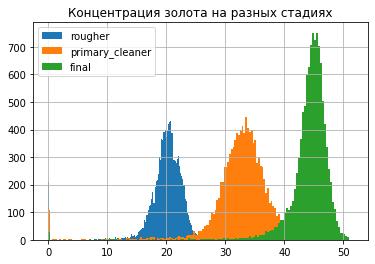

In [14]:
concentrat('au','золота')

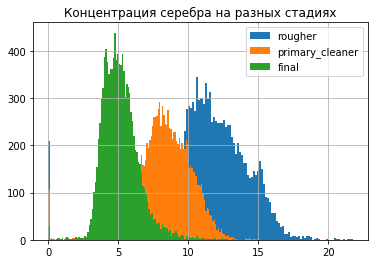

In [15]:
concentrat('ag','серебра')

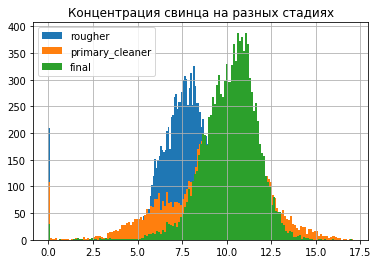

In [16]:
concentrat('pb','свинца')

Концентрация золота растет от стадии к стадии. Концентрация свинца растет с примерно 7.5 в среднем, до 10. Концентрация серебра становится меньше.

### Распределение размеров гранул

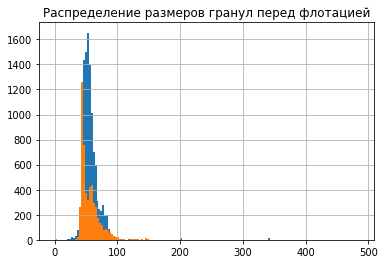

In [17]:
data_train['rougher.input.feed_size'].hist(bins=150,alpha=1)
data_test['rougher.input.feed_size'].hist(bins=150,alpha=1)
plt.title('Распределение размеров гранул перед флотацией')
plt.show()

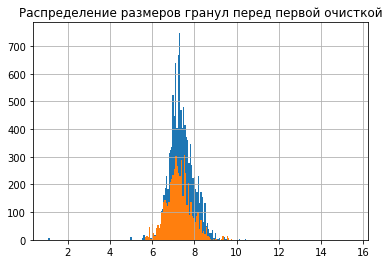

In [18]:
data_train['primary_cleaner.input.feed_size'].hist(bins=150,alpha=1)
data_test['primary_cleaner.input.feed_size'].hist(bins=150,alpha=1)
plt.title('Распределение размеров гранул перед первой очисткой')
plt.show()

Размеры гранул на тестовой и тренировочных выборках имеют одинаковые распределения.

### Суммарные концентрации

In [19]:
summ_fin = (data_train['final.output.concentrate_au']+
            data_train['final.output.concentrate_ag']+
            data_train['final.output.concentrate_pb'])
summ_prim = (data_train['primary_cleaner.output.concentrate_au']+
             data_train['primary_cleaner.output.concentrate_ag']+
             data_train['primary_cleaner.output.concentrate_pb'])
summ_rough = (data_train['rougher.output.concentrate_au']+
              data_train['rougher.output.concentrate_ag']+
              data_train['rougher.output.concentrate_pb'])

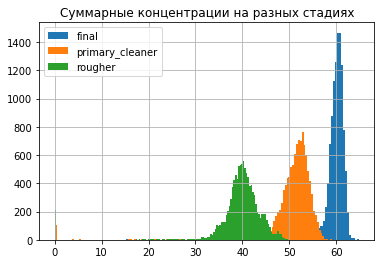

In [20]:
summ_fin.hist(bins=150,alpha=1,label='final')
summ_prim.hist(bins=150,alpha=1,label='primary_cleaner')
summ_rough.hist(bins=150,alpha=1,label='rougher')
plt.title('Суммарные концентрации на разных стадиях')
plt.legend()
plt.show()

### Обработка аномальных значений

На предыдущем графике можно увидеть аномальные значения показывающие суммарную концентрацию равную 0, их можно удалить.

In [21]:
#data_train = data_train.drop(data_train[data_train['primary_cleaner.output.concentrate_au'] == 0].index)

Вывод: на этапе анализа мы рассмотрели концентрацию металлов на разных стадиях, распределение размера гранул в обучающей и тестовой выборках и суммарную концентрацию на разных стадиях. Так же были удалены аномальные значения.

In [22]:
in1 = summ_prim[summ_prim == 0].index

In [23]:
in2 = summ_rough[summ_rough == 0].index

In [24]:
in3 = summ_fin[summ_fin == 0].index

In [25]:
in1

Int64Index([   19,    22,    30,    73,    76,    91,    92,   825,  1577,
             2057,  2077,  2087,  2216,  5664,  5953,  6665,  6666,  6667,
             6668,  6756,  7748,  7883,  7884,  7885,  7886,  7887,  7888,
             7939,  7940,  7947,  8024,  8025,  8229,  8230,  9325,  9326,
             9327,  9334,  9335, 10042, 10158, 10294, 10455, 11033, 11034,
            11035, 11036, 11037, 12146, 12280],
           dtype='int64')

In [26]:
sum_index = set(list(in1) + list(in2) + list(in3))

In [27]:
data_train = data_train.drop(sum_index)

## Модель

### Подготовка выборок к обучению моделей.

In [28]:
data_train.drop(miss_columns, axis=1, inplace = True)

In [29]:
train = data_train.merge(data_full[['date', 'rougher.output.recovery', 'final.output.recovery']], 
                         how = 'left', on = 'date')

In [30]:
test = data_test.merge(data_full[['date', 'rougher.output.recovery', 'final.output.recovery']], 
                       how = 'left', on = 'date')

In [31]:
test = test.dropna()
train = train.dropna()

In [32]:
target_train = train[['rougher.output.recovery', 'final.output.recovery']]
features_train = train.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)
target_test = test[['rougher.output.recovery','final.output.recovery']]
features_test = test.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)
    

### sMAPE

In [33]:
def smape(target, prediction):
    smape = (1/len(target))*(abs(prediction - target)/((abs(target)+abs(prediction))/2)).sum()*100
    return smape

In [34]:
def fsmape(rougher,final):
    smape_final_1 = 0.25 * rougher + 0.75 * final
    return smape_final_1

#### LinearRegression

In [35]:
scorer = make_scorer(smape, greater_is_better=False)

model = LinearRegression()
params = {}

In [36]:
grid_lr = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring=scorer)

In [37]:
grid_lr.fit(features_train, target_train["rougher.output.recovery"])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='warn', n_jobs=None, param_grid={}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False,
             scoring=make_scorer(smape, greater_is_better=False), verbose=0)

In [38]:
grid_lr.best_score_

-6.158354412111992

#### RandomForestRegressor

In [39]:
model = RandomForestRegressor(random_state=4212342)
params = {'n_estimators' : [i for i in range(10,20,2)],
          'max_depth' : [i for i in range(5,7)]}

In [40]:
grid_rf_r = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring=scorer)
grid_rf_f = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring=scorer)

In [41]:
%%time
grid_rf_r.fit(features_train, target_train['rougher.output.recovery'])
grid_rf_f.fit(features_train, target_train['final.output.recovery'])
print(grid_rf_r.best_params_)
print(grid_rf_f.best_params_)
fsmape(grid_rf_r.best_score_,grid_rf_f.best_score_)

{'max_depth': 5, 'n_estimators': 16}
{'max_depth': 6, 'n_estimators': 10}
CPU times: user 3min 57s, sys: 135 ms, total: 3min 57s
Wall time: 4min 2s


-8.146570996815727

#### Lasso

In [42]:
model = Lasso(random_state=4212342)
params = {'alpha' : np.linspace(0.1, 3, 10)}

In [43]:
grid_lasso_r = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring=scorer)
grid_lasso_f = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring=scorer)

In [44]:
%%time
grid_lasso_r.fit(features_train, target_train['rougher.output.recovery'])
grid_lasso_f.fit(features_train, target_train['final.output.recovery'])
print(grid_lasso_r.best_params_)
print(grid_lasso_f.best_params_)
fsmape(grid_lasso_r.best_score_,grid_lasso_f.best_score_)

{'alpha': 0.42222222222222217}
{'alpha': 0.1}
CPU times: user 1min 12s, sys: 59.7 s, total: 2min 11s
Wall time: 2min 11s


-8.11747412847848

### Проверим модели на тесте:

In [45]:
def RF(f_train,t_train,f_test,t_test,nest,md):

    model = RandomForestRegressor(random_state=4212342, n_estimators = nest, max_depth = md)
    model.fit(f_train,t_train)
    prediction = model.predict(f_test)
    prediction = pd.Series(prediction)
    smape1 = smape(t_test, prediction)

    return smape1

In [46]:
def L(f_train,t_train,f_test,t_test,al):

    model = Lasso(random_state=4212342, alpha=al)
    model.fit(f_train,t_train)
    prediction = model.predict(f_test)
    prediction = pd.Series(prediction)
    smape1 = smape(t_test, prediction)

    return smape1

In [47]:
RF_r = RF(features_train,target_train['rougher.output.recovery'],
          features_test,target_test['rougher.output.recovery'],
          grid_rf_r.best_params_['n_estimators'],grid_rf_r.best_params_['max_depth'])
RF_f = RF(features_train,target_train['final.output.recovery'],
          features_test,target_test['final.output.recovery'],
          grid_rf_f.best_params_['n_estimators'],grid_rf_f.best_params_['max_depth'])
RF_fsmape = fsmape(RF_r,RF_f)
print('RandomForestRegressor sMApe: ',RF_fsmape)

RandomForestRegressor sMApe:  9.769040784769109


In [48]:
L_r = L(features_train,target_train['rougher.output.recovery'],
          features_test,target_test['rougher.output.recovery'],
          grid_lasso_r.best_params_['alpha'])
L_f = L(features_train,target_train['final.output.recovery'],
          features_test,target_test['final.output.recovery'],
          grid_lasso_f.best_params_['alpha'])
L_fsmape = fsmape(L_r,L_f)
print('Lasso sMApe: ',L_fsmape)

Lasso sMApe:  9.00044447977511


### Проверка адекватности модели на Dummy регрессоре

In [49]:
dummy = DummyRegressor(strategy="mean")

In [50]:
dummy.fit(features_train, target_train["rougher.output.recovery"])
prediction_roh = dummy.predict(features_test)
dummy.fit(features_train, target_train["final.output.recovery"])
prediction_fin = dummy.predict(features_test)

In [51]:
score = fsmape(smape(prediction_roh, target_test["rougher.output.recovery"]), 
           smape(prediction_fin, target_test["final.output.recovery"]))

print('Dummy sMAPE: ',score)

Dummy sMAPE:  9.336557219082437


Вывод: Были получены и подготовлены данные технологического процесса востановления золота из золотоносной руды. Данные были изучены, проыверена формула recovery и сравнена с табличным значением - по минимальному различию показателя МАЕ выявлено что данные не отличаются. Был проведен анализ данных - были рассмотрены изменение концентрации металлов на разных этапах, проанализированы распределения размеров гранул - они оказались распределены одинаково. Исследованы суммарные концентрации веществ и по результатам были удалены аномальные значния. Исследованы модели машинного обучения Lasso, RandomForestRegressor, LinearRegressionи мы выяснили что лучшая модель - Lasso и она оказалась лучше чем DummyRegressor.